**To-do list**

* ~~Implement usage of structural constraint in GP CaKe.~~
* Run some simulations to test efficacy of EB method for parameter selection.
* ~~Add diagnostic tools.~~
* Add method for setting last parameters (i.e. temporal localization).
* Add univariate approach for large networks.
* Make transposition of (adj_mat, ground_truth) and (parameter_matrices, structural_constraint) consistent. Currently the latter is transposed with respect to the others. Flipping the indices in rearrange_matrix does not seem to be sufficient??
* Use edge-wise noise level and time scale.
* Alternative to K-means: edge-wise estimates.
* Make plotting function generic (i.e. ground truth, scale, etc.)

In [2]:
%matplotlib inline
import numpy as np
import importlib as imp
#from importlib import reload # for python 3

"""
Simulation and GP-CaKe packages.
"""

import simulator as sim
import gpcake
import utility
#import matplotlib.pyplot as plt
import diagnostics

In [24]:
p                       = 3
adj_mat                 = np.zeros((p,p))
adj_mat[0,1]            = 1
adj_mat[0,2]            = 1
connection_strength     = 1
time_step               = 0.01
time_period             = 4.
time_range              = np.arange(-time_period / 2, time_period / 2, time_step)
ntime_points            = int(time_period / time_step)
simulation_params       = {'network'                : adj_mat,
                           'connection_strength'    : connection_strength,
                           'time_step'              : time_step,
                           'time_period'            : time_period}

ntrials_train                                       = 300
ntrials_test                                        = 300
simulation                                          = sim.integroDifferential_simulator()
simulation.dynamic_parameters["connectivity_relaxations_constants"] = [[0.0,8.0],[8.0,0.0]]
connectivity_relaxation = 10.
(training_samples, testing_samples, ground_truth)   = simulation.simulate_network_dynamics(ntrials_train, 
                                                                                           ntrials_test, 
                                                                                           simulation_params,
                                                                                           connectivity_relaxation = connectivity_relaxation)

Plot a few samples to see the generated time series.

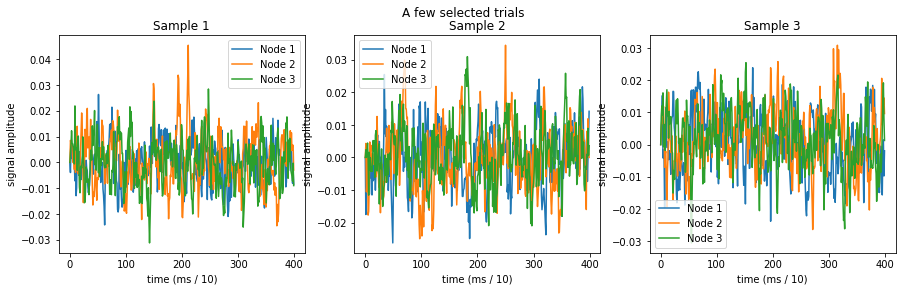

In [25]:
diagnostics.plot_samples(training_samples[0:3])

In [26]:
reload(gpcake)
reload(utility)
reload(diagnostics)
cake = gpcake.gpcake()
cake.initialize_time_parameters(time_step, time_period, ntime_points)
cake.dynamic_parameters["number_sources"] = p
cake.dynamic_type = "Relaxation"
cake.dynamic_parameters = simulation.dynamic_parameters
# This should be replaced by the univariate likelihood maximization for empirical data.

Training GP CaKe parameters with empirical Bayes.
Connectivity constraint: disabled.
Empirical Bayes procedure complete.


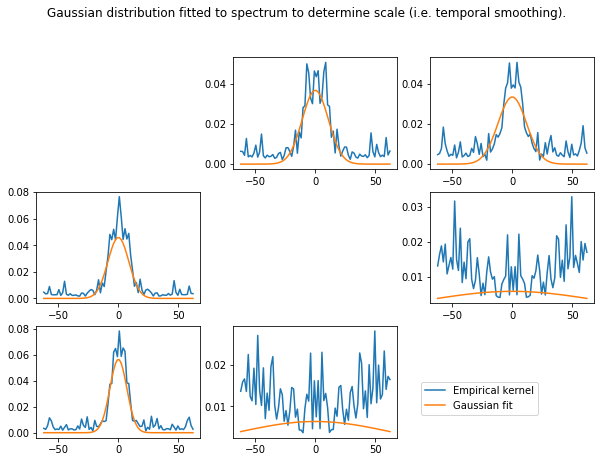

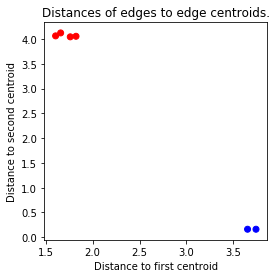

In [27]:
parameter_dict = cake.empirical_bayes_parameter_fit(training_samples, show_diagnostics=True)
# Note: our analysis fails if p=2, which induces symmetric log-likelihood ratios and scales,
# which causes their std to be 0 and hence the normalization throws an error.

GP CaKe parameters:

Time scales (nu_ij):
[[ 0.          0.10953898  0.10953898]
 [ 0.10953898  0.          0.01528864]
 [ 0.10953898  0.01528864  0.        ]]

Time shifts (t_ij):
[[ 0.          0.10953898  0.10953898]
 [ 0.10953898  0.          0.01528864]
 [ 0.10953898  0.01528864  0.        ]]

Spectral smoothing: (theta_ij)
[[  0.          10.95389766  10.95389766]
 [ 10.95389766   0.           1.52886387]
 [ 10.95389766   1.52886387   0.        ]]

Noise levels (sigma_i):
[ 0.63630606  0.66351172  0.66351172]

Connectivity constraint (G_ij):
[[ 0.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  0.]]
Elapsed time is 27.6905970573 seconds.
MSE: 0.018869
MSE: 0.018869


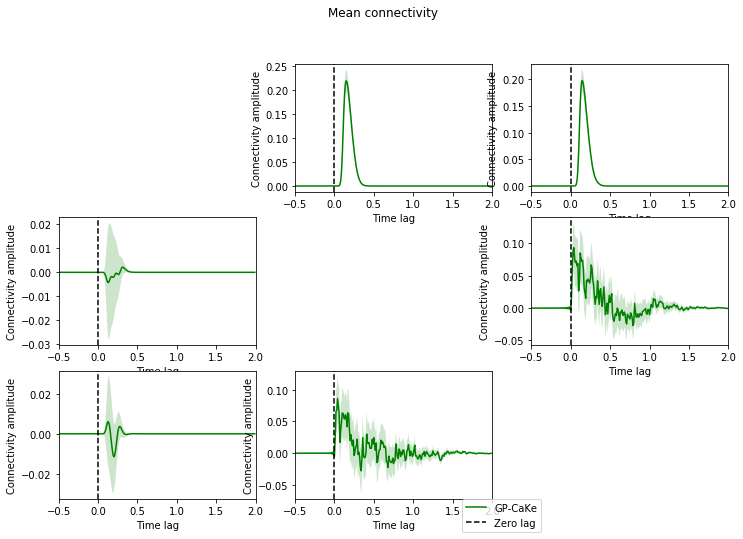

In [28]:
cake.parallelthreads = 1 # parallelization is broken after latest patch
connectivity = cake.run_analysis(testing_samples, show_diagnostics=True)
diagnostics.plot_connectivity(ground_truth, connectivity, time_range, t0=-0.5)

mse_scores = diagnostics.estimation_error(ground_truth, connectivity)
print 'MSE: %f' % np.mean(mse_scores)
print 'MSE: %f' % np.mean(mse_scores)

In [29]:
mse_scores = diagnostics.estimation_error(ground_truth, connectivity)
print 'MSE: %f' % np.mean(mse_scores)

MSE: 0.018869
